# Associate fed codes id to business id to geolocate

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import h3
import keplergl

# load detail dataset

In [4]:
df=pd.read_json('bizbuysell.detail.lines.json',
                lines=True, dtype={'s_id':'int64'})

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38571 entries, 0 to 38570
Data columns (total 32 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   s_breadcrumbs              38571 non-null  object 
 1   s_b_desc                   34285 non-null  object 
 2   s_b_name                   34285 non-null  object 
 3   s_b_url                    34285 non-null  object 
 4   s_b_image                  34285 non-null  object 
 5   s_b_local                  34228 non-null  object 
 6   s_b_region                 34285 non-null  object 
 7   s_category                 38435 non-null  object 
 8   s_desc                     38437 non-null  object 
 9   s_similar                  38437 non-null  object 
 10  s_name                     38437 non-null  object 
 11  s_id                       38437 non-null  object 
 12  s_url                      38437 non-null  object 
 13  s_price                    38424 non-null  flo

## A: business id, local, region from structured data

In [6]:
dfa=df[['s_id','s_b_local','s_b_region']]
dfa.columns=['id','local','region']
dfa=dfa.dropna()

In [7]:
dfa.head()

,id,local,region
0,2067319,Middlesex,New Jersey
1,1990890,Mays Landing,New Jersey
2,2050006,Randolph,New York
3,2039720,Pinellas,Florida
4,1576680,Baltimore,Maryland


## B: business id, local, region from structured data

In [8]:
dfb=df[['s_id','s_local','s_region']]
dfb.columns=['id','local','region']
dfb=dfb.dropna()

In [9]:
dfb.head()

,id,local,region
0,2067319,Middlesex,New Jersey
1,1990890,Mays Landing,New Jersey
2,2050006,Randolph,New York
3,2039720,Pinellas,Florida
4,1576680,Baltimore,Maryland


## C: business id, location from page

In [10]:
dfc=df[['s_id','p_location']]
dfc=dfc.dropna()
dfc=dfc[dfc.p_location!='']

In [11]:
dfc.head()

,s_id,p_location
0,2067319,"Middlesex County, NJ"
1,1990890,"Mays Landing, NJ (Atlantic County)"
2,2050006,"Randolph, NY (Cattaraugus County)"
3,2039720,"Pinellas County, FL"
4,1576680,"Baltimore, MD (Baltimore City County)"


In [12]:
def parse_location(loc):
    a=pd.NA
    b=pd.NA
    c=pd.NA
    d=pd.NA
    loc=loc.replace('(Relocatable)','')
    loc=loc.replace('County','')
    loc= loc.split(',')
    if len(loc)!=2:
        if len(loc)==1 and len(loc[0]):
            a=loc[0].strip()
        return a,b,c,d
    b=loc[0]
    c=loc[1]
    b=b.strip()
    c=c.strip()
    if len(c)==2:
        return a,b,c,d
    d=c[2:]
    d= d.replace('(','')
    d= d.replace(')','')
    d= d.strip()
    c=c[:2]
    return a,b,c,d

In [13]:
dfc['l']=dfc['p_location'].apply(parse_location)
dfc['a']=dfc['l'].apply(lambda x: x[0])
dfc['b']=dfc['l'].apply(lambda x: x[1])
dfc['c']=dfc['l'].apply(lambda x: x[2])
dfc['d']=dfc['l'].apply(lambda x: x[3])

In [14]:
dfc.head()

,s_id,p_location,l,a,b,c,d
0,2067319,"Middlesex County, NJ","(<NA>, Middlesex, NJ, <NA>)",<NA>,Middlesex,NJ,<NA>
1,1990890,"Mays Landing, NJ (Atlantic County)","(<NA>, Mays Landing, NJ, Atlantic)",<NA>,Mays Landing,NJ,Atlantic
2,2050006,"Randolph, NY (Cattaraugus County)","(<NA>, Randolph, NY, Cattaraugus)",<NA>,Randolph,NY,Cattaraugus
3,2039720,"Pinellas County, FL","(<NA>, Pinellas, FL, <NA>)",<NA>,Pinellas,FL,<NA>
4,1576680,"Baltimore, MD (Baltimore City County)","(<NA>, Baltimore, MD, Baltimore City)",<NA>,Baltimore,MD,Baltimore City


## D: business id, local, 2 letter region from page 

In [15]:
dfd=dfc[['s_id','b','c']]
dfd.columns=['id','local','region2']
dfd=dfd.dropna()

In [16]:
dfd.head()

,id,local,region2
0,2067319,Middlesex,NJ
1,1990890,Mays Landing,NJ
2,2050006,Randolph,NY
3,2039720,Pinellas,FL
4,1576680,Baltimore,MD


## E: business id, local, 2 letter region from page

In [17]:
dfe=dfc[['s_id','d','c']]
dfe.columns=['id','local','region2']
dfe=dfe.dropna()

In [18]:
dfe.head()

,id,local,region2
1,1990890,Atlantic,NJ
2,2050006,Cattaraugus,NY
4,1576680,Baltimore City,MD
5,2087638,Saint Clair,MI
7,2051958,LeFlore,OK


# load listings dataset

In [19]:
df=pd.read_json('bizbuysell.list.lines.json',lines=True, dtype={'s_id':'int64'})

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 263592 entries, 0 to 263591
Data columns (total 15 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   s_breadcrumbs  263592 non-null  object 
 1   s_id           263592 non-null  int64  
 2   s_name         263592 non-null  object 
 3   s_desc         263592 non-null  object 
 4   s_url          263592 non-null  object 
 5   s_price        263592 non-null  int64  
 6   s_local        226316 non-null  object 
 7   s_region       247594 non-null  object 
 8   id             261044 non-null  float64
 9   href           261044 non-null  object 
 10  title          261044 non-null  object 
 11  loc            245046 non-null  object 
 12  desc           261044 non-null  object 
 13  asking_price   261044 non-null  object 
 14  cash_flow      127994 non-null  object 
dtypes: float64(1), int64(2), object(12)
memory usage: 30.2+ MB


## F: business id, local, 2 letter region from structured data

In [21]:
dff=df[['s_id','s_local','s_region']]
dff.columns=['id','local','region2']
dff=dff.dropna()

In [22]:
dff.head()

,id,local,region2
1,1815206,Whitwell,TN
2,2023577,Detroit,MI
3,2066007,Poultney,VT
4,27828757,Houston,TX
5,2001472,Orr,MN


## G: business id, local, location from page data

In [23]:
dfg=df[['s_id','loc']]
dfg=dfg.dropna()

In [24]:
dfg.head()

,s_id,loc
0,1972353,Christiansted
1,1815206,"Whitwell, TN"
2,2023577,"Detroit, MI"
3,2066007,"Poultney, VT"
5,2001472,"Orr, MN"


In [25]:
def parse_location(loc):
    a=pd.NA
    b=pd.NA
    loc=loc.split(',')
    if len(loc)!=2:
        return a,b
    a=loc[0].strip()
    b=loc[1].strip()
    return a,b

In [26]:
dfg['l']=dfg['loc'].apply(parse_location)
dfg['local']=dfg['l'].apply(lambda x: x[0])
dfg['region']=dfg['l'].apply(lambda x: x[1])
dfg=dfg[['s_id','local','region']]
dfg.columns=['id','local','region2']
dfg=dfg.dropna()

In [27]:
dfg.head()

,id,local,region2
1,1815206,Whitwell,TN
2,2023577,Detroit,MI
3,2066007,Poultney,VT
5,2001472,Orr,MN
6,1849773,Muenster,TX


# Load fed codes dataset

In [28]:
df_fc=pd.read_pickle('../census/codes/fed_codes.pkl')

In [29]:
df_fc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202532 entries, 0 to 202531
Data columns (total 24 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   FEATURE_ID                202532 non-null  int64         
 1   FEATURE_NAME              202532 non-null  object        
 2   FEATURE_CLASS             202532 non-null  object        
 3   CENSUS_CODE               199595 non-null  object        
 4   CENSUS_CLASS_CODE         201765 non-null  object        
 5   GSA_CODE                  38720 non-null   object        
 6   OPM_CODE                  38720 non-null   object        
 7   STATE_NUMERIC             202532 non-null  int64         
 8   STATE_ALPHA               202532 non-null  object        
 9   COUNTY_SEQUENCE           202532 non-null  int64         
 10  COUNTY_NUMERIC            202532 non-null  int64         
 11  COUNTY_NAME               202509 non-null  object        
 12  PR

In [32]:
# set feature as local
df_fca=df_fc[df_fc.FEATURE_CLASS.isin(['Populated Place','Locale','Census','Military'])]
df_fca=df_fca[['FEATURE_ID','FEATURE_NAME','STATE_ALPHA']]
df_fca.columns=['FEATURE_ID','local','region2']
df_fca.drop_duplicates(subset=['local','region2'], keep='first') 

# set county as local
df_fcb=df_fc[df_fc.CENSUS_CLASS_CODE=='H1'] #County or Equivalent Feature
df_fcb=df_fcb[['FEATURE_ID','COUNTY_NAME','STATE_ALPHA']]
df_fcb.columns=['FEATURE_ID','local','region2']
df_fcb.drop_duplicates(subset=['local','region2'], keep='first') 

df_fcab=pd.concat([df_fca, df_fcb])
df_fcab=df_fcab.dropna()

In [36]:
df_fcab.head()
df_fcab['region']=df_fcab['region2']

# H: Combine A,B and fed codes

In [37]:
dfh=pd.concat([dfa,dfb])
dfh=dfh.drop_duplicates()
dfh=dfh.merge(df_fcab, how='left', on=['local','region'])

In [38]:
dfh.head()

,id,local,region,FEATURE_ID,region2
0,2067319,Middlesex,New Jersey,NaN,NaN
1,1990890,Mays Landing,New Jersey,NaN,NaN
2,2050006,Randolph,New York,NaN,NaN
3,2039720,Pinellas,Florida,NaN,NaN
4,1576680,Baltimore,Maryland,NaN,NaN


In [39]:
dfh_missing=dfh[dfh['FEATURE_ID'].isna()]
dfh_ok=dfh.dropna()

In [40]:
dfh.shape, dfh_ok.shape

((34193, 5), (0, 5))

In [41]:
dfh_ok.shape[0]+dfh_missing.shape[0]

34193

# I: Combine D,E and fed codes

In [42]:
dfi=pd.concat([dfd,dfe])
dfi=dfi.drop_duplicates()
dfi=dfi.merge(df_fcab, how='left', on=['local','region2'])

In [43]:
dfi.head()

,id,local,region2,FEATURE_ID,region
0,2067319,Middlesex,NJ,878315.0,NJ
1,2067319,Middlesex,NJ,882230.0,NJ
2,1990890,Mays Landing,NJ,878206.0,NJ
3,2050006,Randolph,NY,962181.0,NY
4,2039720,Pinellas,FL,295745.0,FL


In [44]:
dfi_missing=dfi[dfi['FEATURE_ID'].isna()]
dfi_ok=dfi.dropna()

In [45]:
dfi.shape, dfi_ok.shape

((81534, 5), (79355, 5))

In [46]:
dfi_ok.shape[0]+dfi_missing.shape[0]

81534

# J: Combine F,G and fed codes

In [47]:
dfj=pd.concat([dff,dfg])
dfj=dfj.drop_duplicates()
dfj=dfj.merge(df_fcab, how='left', on=['local','region2'])

In [48]:
dfj.head()

,id,local,region2,FEATURE_ID,region
0,1815206,Whitwell,TN,NaN,NaN
1,2023577,Detroit,MI,NaN,NaN
2,2066007,Poultney,VT,NaN,NaN
3,27828757,Houston,TX,NaN,NaN
4,2001472,Orr,MN,NaN,NaN


In [49]:
dfj_missing=dfj[dfj['FEATURE_ID'].isna()]
dfj_ok=dfj.dropna()

In [50]:
dfj.shape, dfj_ok.shape

((78292, 5), (31652, 5))

In [51]:
dfj_ok.shape[0]+dfj_missing.shape[0]

78292

# Combine H,I,J

In [52]:
#the dataset is orderd by most accurate to less accurate locations so keep the first duplicate
dfhij=pd.concat([dfh,dfi,dfj])
dfhij=dfhij.dropna()
dfhij=dfhij.drop_duplicates(subset=['id'], keep='first')
dfhij=dfhij[['id','FEATURE_ID']]

In [53]:
dfhij.head()

,id,FEATURE_ID
0,2067319,878315.0
2,1990890,878206.0
3,2050006,962181.0
4,2039720,295745.0
5,1576680,597040.0


In [54]:
dfhij.shape

(56283, 2)

In [55]:
dfhij.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56283 entries, 0 to 78291
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          56283 non-null  object 
 1   FEATURE_ID  56283 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.3+ MB


In [56]:
dfhij.to_pickle('bizbuysell_id_to_feature_id.pkl')

# Top states

In [57]:
df_g=dfhij.merge(df_fc,how='left',on='FEATURE_ID')

In [58]:
by_state=df_g.groupby('STATE_ALPHA')['id'].count().reset_index()
by_state=by_state.sort_values('id',ascending=False)
by_state.columns=['state','business for sale']
by_state[:15]

,state,business for sale
43,TX,10087
4,CA,8188
9,FL,7800
34,NY,3532
10,GA,2700
3,AZ,2143
27,NC,2039
38,PA,1982
5,CO,1970
14,IL,1960


# Top counties

In [59]:
by_county=df_g
by_county['county']= by_county['COUNTY_NAME'] + ', ' + by_county['STATE_ALPHA']
by_county=by_county.groupby('county')['id'].count().reset_index()
by_county=by_county.sort_values('id',ascending=False)
by_county.columns=['county','business for sale']
by_county[:20]

,county,business for sale
980,"Los Angeles, CA",2378
1026,"Maricopa, AZ",1482
687,"Harris, TX",1198
1098,"Miami-Dade, FL",1083
554,"Fort Bend, TX",1027
449,"Denton, TX",999
1228,"Orange, CA",955
1142,"Montgomery, TX",867
167,"Broward, FL",865
370,"Cook, IL",829


# Scatter plot locations

<Axes: xlabel='PRIMARY_LONGITUDE', ylabel='PRIMARY_LATITUDE'>

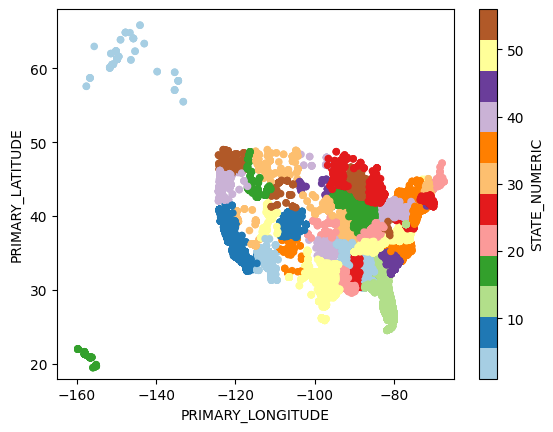

In [60]:
df_g.plot(x="PRIMARY_LONGITUDE", y="PRIMARY_LATITUDE", 
        kind="scatter", c="STATE_NUMERIC", colormap="Paired",xlim=(-165,-65),ylim=(18,68))

# Kepler graph

In [61]:
df_g['H3_5']=df_g['H3_15'].apply(lambda x: h3.h3_to_parent(x,5))

In [62]:
data1=df_g.groupby('H3_5')['id'].count().reset_index() 
data1.columns=['hex_id','value']

In [63]:
w1 = keplergl.KeplerGl(height=600, data={'business count': data1})
w1

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'business count':                hex_id  value
0     850c0c63fffffff      1
1     850c4417fffff…